<a href="https://colab.research.google.com/github/art-glazunov/Non-standard-categorical-encodings/blob/main/group_counts_and_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-standard categorical encodings
by Artyom Glazunov
#Part 2.2. Group counts + Entropy calculation

### In this notebook, you can check out how group counts and entropy calculation can help with categorical encoding and getting object embeddings in unsupervised manner. Such embeddings can be useful for solving many supervised and unsupervised learning tasks.
Inspired by https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Group2Vec/Group2Vec.ipynb



In [ ]:
import pandas as pd
import numpy as np

import itertools
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE, MDS
from scipy.stats import entropy


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from typing import List, NewType
EntropyCategoricalEmbedderObject = NewType('EntropyCategoricalEmbedderObject', object) #creating new type to annotate in our class

Download our train dataset from https://www.kaggle.com/c/cat-in-the-dat/data?select=train.csv into your directory, here I use a folder on my Google Drive to store the data. Of course, you can simply load the data into the folder on the left, without Google Drive. But if you want to mount your drive, you can do as instructed here https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166, *or just use a button on the left panel*). 

Change working dir

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/article

/content/drive/MyDrive/Colab_Notebooks/article


Check the folder 

In [ ]:
!ls

group_counts_and_entropy.ipynb	group_counts_and_SVD.ipynb  train.csv


Our file is here, let's load the data and split it into train and test parts

In [ ]:
data = pd.read_csv('train.csv', index_col = 'id')
train = data.iloc[:-70000]
print(train.shape)
train.head()

(230000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [ ]:
test = data.iloc[-70000:]
print(test.shape)
test.head()

(70000, 24)


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
230000,1,1,0,F,Y,Green,Square,Dog,Russia,Piano,92190168b,fa498a5ae,d10553e7e,80be47228,47d38e9d3,1,Master,Lava Hot,e,U,MO,4,2,0
230001,0,0,0,T,Y,Red,Star,Lion,Canada,Piano,e7d9ca356,0b23e3352,40f84f6de,333f46907,e9e56a3f8,1,Expert,Boiling Hot,i,O,CM,1,1,0
230002,0,0,0,F,Y,Red,Circle,Cat,Canada,Bassoon,a3f640358,9b1c3c8b7,d1586e0e0,1b9339c49,973983691,3,Grandmaster,Freezing,b,T,RL,3,8,1
230003,1,0,0,T,N,Green,Trapezoid,Hamster,Costa Rica,Bassoon,0b3bec656,603232dea,5387ed7d2,da8be1022,508c9de37,1,Novice,Warm,e,U,Qo,2,11,0
230004,1,0,0,T,Y,Blue,Star,Axolotl,Canada,Piano,4173a0252,c135cdf77,91cd074b1,1a2fd4686,75193d88a,3,Novice,Hot,g,U,LE,4,12,1


Select only features

In [ ]:
categorical_cols = [col for col in train.columns if col != 'target']
print(categorical_cols)
len(categorical_cols)

['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']


23

So, get the data in a convenient format

In [ ]:
X_train = train[categorical_cols]
y_train = train['target']
X_test = test[categorical_cols]
y_test = test['target']

### Create a custom class for our embedder

In [ ]:
class EntropyCategoricalEmbedder:
    """Unsupervised categorical embedder based on group counts and entropy calculation

    fit - get dictionary for the transformation of categorical objects into embeddings 
    transform - map the dictionary onto your categorical dataset to get the embeddings
    """

    def __init__(self):
        self.substitute_dict = {} #resulting dictionary to transform the objects into embs

    def __repr__(self):
        return self.__class__.__name__ + "()"
    
    @staticmethod
    def cat_prep(data: pd.DataFrame) -> pd.DataFrame:
        """change category names for simplification

        format -> category-name_category-name
        """

        data_new = data.copy()
        for col in tqdm(data.columns):
          data_new[col] = data[col].apply(lambda x: col + '_' + str(x))
        return data_new
    
    def fit(self, df_train: pd.DataFrame, verbose: bool = True) -> EntropyCategoricalEmbedderObject: # we created this custom type earlier
        """Create dictionary to map on the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep) 
        (each row is our object to get an embedding for)
        """
        
        feature_list = list(df_train.columns)
        df = df_train.copy()
        df['id'] = df.index
        for group_key in tqdm(feature_list):    
            passive_keys = feature_list[:]
            passive_keys.remove(group_key)

            category_embedding_mapping = {}
            for passive_key in passive_keys:
                if verbose:
                    print('--- groupby: group_key - ', group_key, '### passive_key - ', passive_key, '---')                
                group = df.groupby([group_key, passive_key])['id'].count()
                group = group.unstack().fillna(0)
                entropy_values = group.apply(entropy, axis=1)
                for cat, entropy_value in entropy_values.to_dict().items():
                    if cat in category_embedding_mapping:
                        category_embedding_mapping[cat].extend([entropy_value]) 
                    else:
                        category_embedding_mapping[cat] = [entropy_value]
                
            self.substitute_dict[group_key] = category_embedding_mapping  
        return self

    def transform(self, dataset: pd.DataFrame, 
                  fill_unknown_cat_value: int = 0,
                  verbose: bool = False) -> List[list]:
        """Get embedding for each categorical row of the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep) 
        (each row is our object to get an embedding for)
        fill_unknown_cat_value - the value to fill embedding vector for unknown categories
        """

        dataset = dataset.copy()
        feature_list = list(dataset.columns)        
        emb_size = len(feature_list) - 1
        if verbose:
          print("Mapping vectors to categories...")
        for f in tqdm(feature_list):
            dataset[f] = dataset[f].map(self.substitute_dict[f])              
            dataset[f] = dataset[f].fillna('empty')
            dataset[f] = dataset[f].apply(lambda x: [fill_unknown_cat_value] * emb_size if x == 'empty' else x)
        
        embeddings_list = []
        if verbose:
          print("Creating an embedding for each row...")
        for row in tqdm(dataset[feature_list].itertuples()):
            embeddings_list.append(list(itertools.chain(*row[1:])))

        return embeddings_list


Let's use our preprocessing method to prepare the dataset for the embedder

In [ ]:
df_train = X_train.copy()
df_train = EntropyCategoricalEmbedder.cat_prep(df_train)
df_train.head()

  0%|          | 0/23 [00:00<?, ?it/s]

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
0,bin_0_0,bin_1_0,bin_2_0,bin_3_T,bin_4_Y,nom_0_Green,nom_1_Triangle,nom_2_Snake,nom_3_Finland,nom_4_Bassoon,nom_5_50f116bcf,nom_6_3ac1b8814,nom_7_68f6ad3e9,nom_8_c389000ab,nom_9_2f4cb3d51,ord_0_2,ord_1_Grandmaster,ord_2_Cold,ord_3_h,ord_4_D,ord_5_kr,day_2,month_2
1,bin_0_0,bin_1_1,bin_2_0,bin_3_T,bin_4_Y,nom_0_Green,nom_1_Trapezoid,nom_2_Hamster,nom_3_Russia,nom_4_Piano,nom_5_b3b4d25d0,nom_6_fbcb50fc1,nom_7_3b6dd5612,nom_8_4cd920251,nom_9_f83c56c21,ord_0_1,ord_1_Grandmaster,ord_2_Hot,ord_3_a,ord_4_A,ord_5_bF,day_7,month_8
2,bin_0_0,bin_1_0,bin_2_0,bin_3_F,bin_4_Y,nom_0_Blue,nom_1_Trapezoid,nom_2_Lion,nom_3_Russia,nom_4_Theremin,nom_5_3263bdce5,nom_6_0922e3cb8,nom_7_a6a36f527,nom_8_de9c9f684,nom_9_ae6800dd0,ord_0_1,ord_1_Expert,ord_2_Lava Hot,ord_3_h,ord_4_R,ord_5_Jc,day_7,month_2
3,bin_0_0,bin_1_1,bin_2_0,bin_3_F,bin_4_Y,nom_0_Red,nom_1_Trapezoid,nom_2_Snake,nom_3_Canada,nom_4_Oboe,nom_5_f12246592,nom_6_50d7ad46a,nom_7_ec69236eb,nom_8_4ade6ab69,nom_9_8270f0d71,ord_0_1,ord_1_Grandmaster,ord_2_Boiling Hot,ord_3_i,ord_4_D,ord_5_kW,day_2,month_1
4,bin_0_0,bin_1_0,bin_2_0,bin_3_F,bin_4_N,nom_0_Red,nom_1_Trapezoid,nom_2_Lion,nom_3_Canada,nom_4_Oboe,nom_5_5b0f5acd5,nom_6_1fe17a1fd,nom_7_04ddac2be,nom_8_cb43ab175,nom_9_b164b72a7,ord_0_1,ord_1_Grandmaster,ord_2_Freezing,ord_3_a,ord_4_R,ord_5_qP,day_7,month_8


In [ ]:
df_test = X_test.copy()
df_test = EntropyCategoricalEmbedder.cat_prep(df_test)
df_test.head()

  0%|          | 0/23 [00:00<?, ?it/s]

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
230000,bin_0_1,bin_1_1,bin_2_0,bin_3_F,bin_4_Y,nom_0_Green,nom_1_Square,nom_2_Dog,nom_3_Russia,nom_4_Piano,nom_5_92190168b,nom_6_fa498a5ae,nom_7_d10553e7e,nom_8_80be47228,nom_9_47d38e9d3,ord_0_1,ord_1_Master,ord_2_Lava Hot,ord_3_e,ord_4_U,ord_5_MO,day_4,month_2
230001,bin_0_0,bin_1_0,bin_2_0,bin_3_T,bin_4_Y,nom_0_Red,nom_1_Star,nom_2_Lion,nom_3_Canada,nom_4_Piano,nom_5_e7d9ca356,nom_6_0b23e3352,nom_7_40f84f6de,nom_8_333f46907,nom_9_e9e56a3f8,ord_0_1,ord_1_Expert,ord_2_Boiling Hot,ord_3_i,ord_4_O,ord_5_CM,day_1,month_1
230002,bin_0_0,bin_1_0,bin_2_0,bin_3_F,bin_4_Y,nom_0_Red,nom_1_Circle,nom_2_Cat,nom_3_Canada,nom_4_Bassoon,nom_5_a3f640358,nom_6_9b1c3c8b7,nom_7_d1586e0e0,nom_8_1b9339c49,nom_9_973983691,ord_0_3,ord_1_Grandmaster,ord_2_Freezing,ord_3_b,ord_4_T,ord_5_RL,day_3,month_8
230003,bin_0_1,bin_1_0,bin_2_0,bin_3_T,bin_4_N,nom_0_Green,nom_1_Trapezoid,nom_2_Hamster,nom_3_Costa Rica,nom_4_Bassoon,nom_5_0b3bec656,nom_6_603232dea,nom_7_5387ed7d2,nom_8_da8be1022,nom_9_508c9de37,ord_0_1,ord_1_Novice,ord_2_Warm,ord_3_e,ord_4_U,ord_5_Qo,day_2,month_11
230004,bin_0_1,bin_1_0,bin_2_0,bin_3_T,bin_4_Y,nom_0_Blue,nom_1_Star,nom_2_Axolotl,nom_3_Canada,nom_4_Piano,nom_5_4173a0252,nom_6_c135cdf77,nom_7_91cd074b1,nom_8_1a2fd4686,nom_9_75193d88a,ord_0_3,ord_1_Novice,ord_2_Hot,ord_3_g,ord_4_U,ord_5_LE,day_4,month_12


Initialize an embedder

In [ ]:
embedder = EntropyCategoricalEmbedder()
embedder

EntropyCategoricalEmbedder()

In [ ]:
%%time
embedder.fit(df_train, verbose=False)

  0%|          | 0/23 [00:00<?, ?it/s]

CPU times: user 35.9 s, sys: 462 ms, total: 36.4 s
Wall time: 36.3 s


EntropyCategoricalEmbedder()

In [ ]:
%%time
train_feat = embedder.transform(df_train)

  0%|          | 0/23 [00:00<?, ?it/s]

0it [00:00, ?it/s]

CPU times: user 7.79 s, sys: 433 ms, total: 8.22 s
Wall time: 8.18 s


In [ ]:
%%time
test_feat = embedder.transform(df_test)

  0%|          | 0/23 [00:00<?, ?it/s]

0it [00:00, ?it/s]

CPU times: user 3.16 s, sys: 218 ms, total: 3.38 s
Wall time: 3.36 s


Let's look at our embeddings

In [ ]:
np.array(test_feat)

array([[0.56476913, 0.66604397, 0.69291283, ..., 3.12228551, 5.07155551,
        1.70702943],
       [0.56976774, 0.66525145, 0.69286518, ..., 3.12214316, 5.06463587,
        1.71082852],
       [0.56976774, 0.66525145, 0.69286518, ..., 3.12415566, 5.06408276,
        1.71545568],
       ...,
       [0.56976774, 0.66525145, 0.69286518, ..., 3.127963  , 5.0678695 ,
        1.70882849],
       [0.56976774, 0.66525145, 0.69286518, ..., 3.12415566, 5.06408276,
        1.71545568],
       [0.56976774, 0.66525145, 0.69286518, ..., 3.12038487, 5.06101374,
        1.71209282]])

You can see that we have less problems with scale of the components, that's nice!

In [ ]:
np.array(test_feat).shape

(70000, 506)

Estimate of OHE dimensionality

In [ ]:
number_of_cat = 0
for col in df_train.columns:
  number_of_cat += df_train[col].unique().shape[0]
number_of_cat

16380

You can see that the dimensionality of the embedding is 506 against 16 000 in the case of using OHE!

### Here we'll test it via our classification task. How much information we've preserved?

LightGBM.

In [ ]:
%%time
lgmb_clf = lgb.LGBMClassifier(random_state=33).fit(train_feat, y_train)

CPU times: user 2min 48s, sys: 1.62 s, total: 2min 49s
Wall time: 51 s


In [ ]:
probs = lgmb_clf.predict_proba(test_feat)
score_lgbm = roc_auc_score(y_test, probs[:,1])
print(score_lgbm)

0.7678731665784


Let's look at feature importances

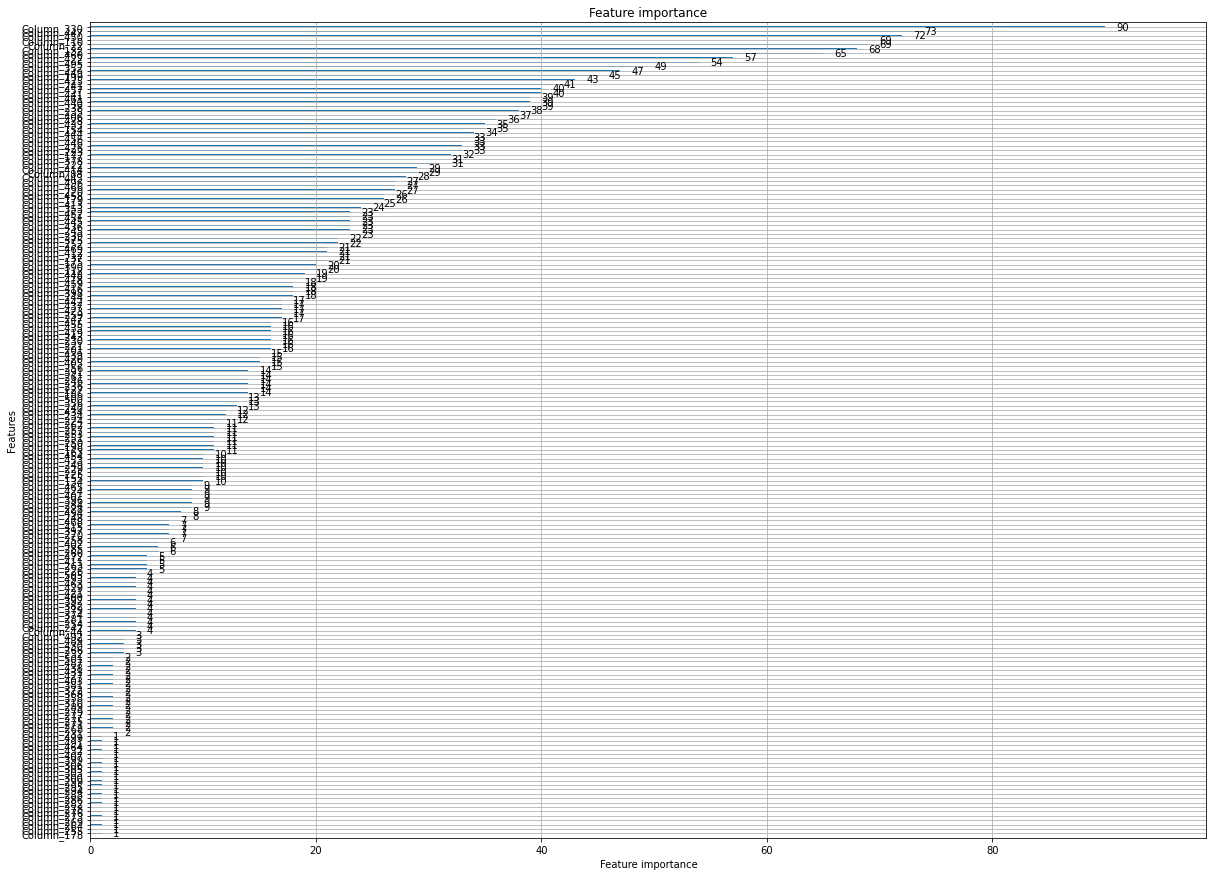

In [ ]:
lgb.plot_importance(lgmb_clf, importance_type='split', figsize=(20, 15));

### In this case we have more balanced distribution of the feature importances than in the previous cases! Not bad :) 

Logistic Regression



In [ ]:
%%time
lr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', LogisticRegression())])
lr_pipe.fit(train_feat, y_train)

CPU times: user 1min 2s, sys: 10 s, total: 1min 12s
Wall time: 33.7 s


In [ ]:
probs = lr_pipe.predict_proba(test_feat)
score_lr_scaled = roc_auc_score(y_test, probs[:, 1])
print(score_lr_scaled)

0.739932540320303


Conclusions:

Pros:
-	Fast
-	High quality embeddings
-	Lower dimensionality of embeddings
-	Good fit for medium-sized data with many high cardinality variables
- More balanced distribution of feature importances

Cons:
-	What to do if we have lots of low cardinality variables?
-	Fixed dimensionality of embeddings
-	Scaling? But less than in the previous method
-	Correlation?


# Visualization

Generate a subsample to visualize.

In [ ]:
_, emb_sample, _, _ = train_test_split(test_feat, y_test, test_size=0.03, random_state=78)

Scale the data


In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(train_feat)

scaled_emb = scaler.transform(emb_sample)

CPU times: user 7.36 s, sys: 48 ms, total: 7.41 s
Wall time: 7.37 s


t-SNE

In [ ]:
%%time
tsne = TSNE(n_components=2, random_state=33)
T = tsne.fit_transform(scaled_emb)

CPU times: user 55.5 s, sys: 130 ms, total: 55.6 s
Wall time: 17.8 s


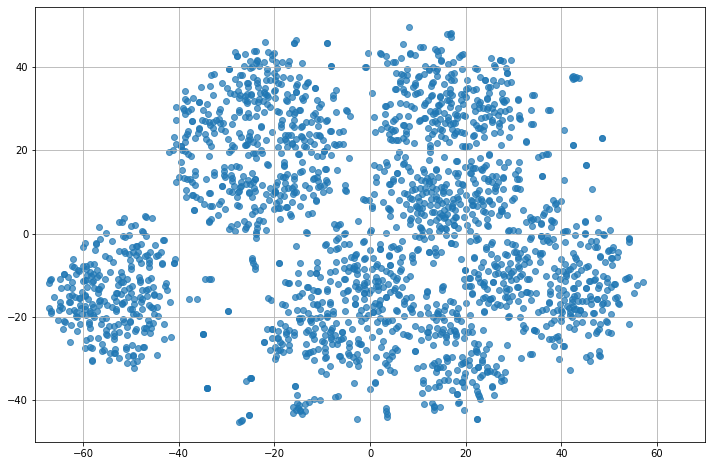

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(T[:, 0], T[:, 1], alpha=0.7)
plt.xlim((-70, 70))
plt.grid()

### Lots of clusters! I like it :)

MDS

In [ ]:
%%time
mds_trans = MDS(n_components=2, random_state=33)
M = mds_trans.fit_transform(scaled_emb)

CPU times: user 3min 50s, sys: 6min 37s, total: 10min 28s
Wall time: 2min 43s


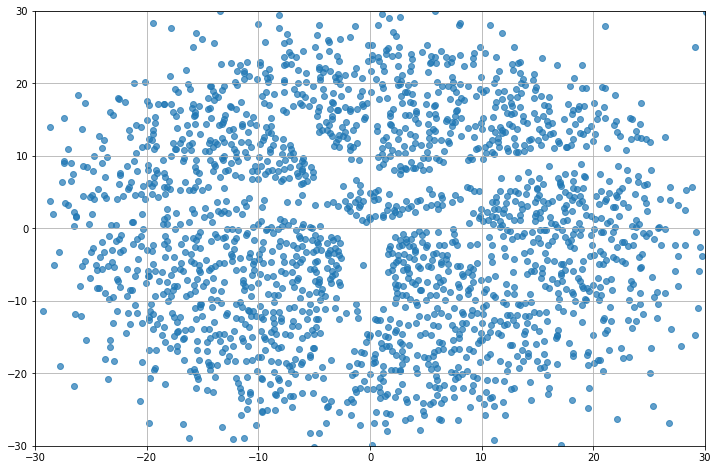

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(M[:, 0], M[:, 1], alpha=0.7)
plt.xlim((-30, 30))
plt.ylim((-30, 30))
plt.grid()

### And... Here we have clusters too! I like it even more :) So, if you want to find some structure in your objects and visualize it, try this encoding method!